In [18]:
from ts_vae.data_processors.ts_gen_processor import TSGenDataset
from torch_geometric.data import DataLoader
import torch
import numpy as np
# from ts_vae.utils import remove_files
# remove_files() 
rxns = TSGenDataset(r'data')
rxns[0]
###
tt_split = 0.889
num_rxns = len(rxns)
num_train = int(np.floor(tt_split * num_rxns))
batch_size = 2
train_loader = DataLoader(rxns[: num_train], batch_size = batch_size)
test_loader = DataLoader(rxns[num_train: ], batch_size = batch_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#for inputs in train_loader:
#    inputs = inputs.to(device)
###
batch = next(iter(train_loader))
test = batch.edge_attr

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from experiments.building_on_mit.meta_eval.meta_eval import ablation_experiment
# from ts_vae.utils import remove_files
# remove_files()
train_log, test_log = ablation_experiment(tt_split = 0.889, epochs = 10, test_interval = 10, \
                                          batch_size = 8, h_nf = 256, n_layers = 2, gnn_depth = 3)

# full params for 20 epochs, ran everything, took 2500s, test_interval=2 worked first time not on second; ~2m for each epoch

# tt_split=0.889, gives 842 test rxns
# batch_size = 8, h_nf = 128, n_layers = 1, gnn_depth = 2  ==> 5 epochs=10m
# batch_size = 32, h_nf = 128, n_layers = 2, gnn_depth = 3 ==> 

# no mlp, loss is worse by ~0.15 and get stranger D_inits
# no tranpose: almost identical results

# gnn + dw, no recon, train on D_init: e=10,b=32,h/n/g=standard
#   - just init: 
#       2,3 --> one peak at ~7.5
#   - init + gnn w node: e=10-time=90s; e=20, time=180s
#       6 --> one enormous peak at ~7.5, extremely similar matrices
#       7 --> more of a distr but weird
#       8 --> e=20: much better shape (bimodal) but shifted to 5-7.5
#       9 --> e=20: back to enormous peak at ~7.5
#   - init + gnn w edge: e=10-time=200s
#      10 --> time=200s: bimodal but v flat and wide from 1-8A, matrices more different
#      11 --> e=20-time=400s: trimodal (two big one small) from around 4-10A
#      12 --> b=8-time=260s: trimodal (two big one small) from around 4-10A
#      notes: this change causes more diff matrices and bimodality
#   - init + gnn w edge, node
#       4,5 --> more bimodal (like gt), bigger peak ~6.5, smaller peak ~8.7
#       13 --> time=290s: unimodal ~1 (much nearer GT) but long low tail to 8A
#       14 --> b=8-time=380s: unimodal ~5.8, low and flat, gaussian-looking
#       15 --> b=8,e=20-time=760s: similar to 14 but more bimodal (and weird)
#   - other notes: training decreasing from ~5.3 -> ~3.7
# gnn + dw + recon no opt, train on X->D: e=10,b=8,h/n/g=standard
#   - gram + low rank, no opt: 
#       16 --> flat like a uniform from 3-7A
#       17 --> unimodal ~4A from 2-6A, matrices looking double what they should be
#       with only f_i not f_j: bottom triangle is double
#       without symmetrise, all elements in matrix are v similar
#       trying with -2 in d_init_const
#       18 --> e=20-time=1000s: with -2 d_init_const, unimodal produced results ~3.5A
#       19 --> e=20-time= : with -3 d_init_const, v similar matrices
# gnn + dw + recon no opt, train on X: e=20,b=8,h/n/g=standard
#       20 --> same as 19 with diff loss and -2.5 const but getting more differences in matrix
#       21 --> e=10 but same as 20 w -2 const, better range ~1.5-2.5A but unimodal 
#       22 --> e=10 but same as 2- w -2.25 const, range ~2.5-3A and unimodal-ish 



Starting ablation experiment...
===== Training epoch 001 complete with loss: 1.8977 ====
===== Training epoch 002 complete with loss: 1.8840 ====
===== Training epoch 003 complete with loss: 1.8753 ====
===== Training epoch 004 complete with loss: 1.8727 ====
===== Training epoch 005 complete with loss: 1.8665 ====
===== Training epoch 006 complete with loss: 1.8650 ====
===== Training epoch 007 complete with loss: 1.8619 ====
===== Training epoch 008 complete with loss: 1.8581 ====
===== Training epoch 009 complete with loss: 1.8633 ====
===== Training epoch 010 complete with loss: 1.8593 ====
===== Testing epoch 010 complete with loss: 1.8296 ====
Completed ablation experiment, use the experiment log to print results.


In [17]:
file_name = '19.npy'

In [18]:
from rdkit import Chem
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

base_folder = r'data/raw/' # normal
test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
test_r = Chem.SDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]
test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]
test_p = Chem.SDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

# want to create a D_init of [num_train, 21, 21] for plotting
batched_test_Ds = test_log.epoch_ae_results[-1]['D_init']
# test_Ds = torch.cat([D for D in batched_test_Ds], 0)
# test_Ds = test_Ds.detach().cpu().numpy()
test_Ds = np.concatenate([D for D in batched_test_Ds], 0)

# save and load
d_folder = 'experiments/building_on_mit/meta_eval/d_inits/'
D_init = np.load(d_folder + 'mit_best.npy')
np.save(d_folder + file_name, test_Ds)
D_init1 = np.load(d_folder + file_name)
d_inits = []
d_inits.append(D_init1)
num_d_inits = len(d_inits)

In [20]:
print(D_init.shape, D_init1.shape)
np.set_printoptions(precision = 3, threshold = 4, edgeitems = 5, suppress = False)
i = 2
num_atoms = test_ts[i].GetNumAtoms()
print("MIT: \n", D_init[i][0:num_atoms, 0:num_atoms])
print("Mine: \n", D_init1[i][0:num_atoms, 0:num_atoms])
print("GT: \n", Chem.Get3DDistanceMatrix(test_ts[i]))

(842, 21, 21) (842, 21, 21)
MIT: 
 [[0.    1.153 2.62  2.636 3.121 ... 2.783 2.695 3.349 2.903 3.972]
 [1.153 0.    1.159 1.178 2.272 ... 2.207 2.259 2.297 2.493 2.301]
 [2.62  1.159 0.    2.633 3.493 ... 0.919 3.585 2.71  4.416 3.017]
 [2.636 1.178 2.633 0.    2.179 ... 2.862 0.9   0.923 2.288 1.033]
 [3.121 2.272 3.493 2.179 0.    ... 4.834 2.6   2.688 1.004 0.939]
 ...
 [2.783 2.207 0.919 2.862 4.834 ... 0.    4.214 2.742 5.995 4.414]
 [2.695 2.259 3.585 0.9   2.6   ... 4.214 0.    2.265 2.262 2.309]
 [3.349 2.297 2.71  0.923 2.688 ... 2.742 2.265 0.    3.131 1.885]
 [2.903 2.493 4.416 2.288 1.004 ... 5.995 2.262 3.131 0.    2.151]
 [3.972 2.301 3.017 1.033 0.939 ... 4.414 2.309 1.885 2.151 0.   ]]
Mine: 
 [[0.    2.616 2.616 2.616 2.616 ... 2.604 2.604 2.604 2.604 2.604]
 [2.616 0.    2.616 2.616 2.616 ... 2.604 2.604 2.604 2.604 2.604]
 [2.616 2.616 0.    2.616 2.616 ... 2.604 2.604 2.604 2.604 2.604]
 [2.616 2.616 2.616 0.    2.616 ... 2.604 2.604 2.604 2.604 2.604]
 [2.616 2.616

In [13]:
from rdkit import Chem
import torch

def get_euc_dist(X):
    D_sq = torch.square(torch.unsqueeze(X, 1) - torch.unsqueeze(X, 2))
    D = torch.sum(D_sq, 3) + 1e-2
    return D

def sequence_mask(sizes, max_size = 21, dtype = torch.bool, device = 'cpu'):
    row_vector = torch.arange(0, max_size, 1).to(device)
    matrix = torch.unsqueeze(sizes, dim = -1)
    mask = row_vector < matrix
    mask.type(dtype)
    return mask

def loss_dist(X_pred, X_gt, mask_D):
    D_pred = mask_D * get_euc_dist(X_pred)
    D_gt = mask_D * get_euc_dist(X_gt)
    loss_dist_all = mask_D * torch.abs(D_pred - D_gt)
    loss_dist = torch.sum(loss_dist_all) / torch.sum(mask_D)
    return loss_dist

i = 8
base_folder = r'data/raw/' # normal
test_ts_file = base_folder + 'test_ts.sdf'
test_ts = Chem.SDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]
num_atoms = test_ts[i].GetNumAtoms()
D_gt = torch.from_numpy(Chem.Get3DDistanceMatrix(test_ts[i]))

d_folder = 'experiments/building_on_mit/meta_eval/d_inits/'
D_init1 = np.load(d_folder + file_name)
D_pred = torch.from_numpy(D_init1[i][0:num_atoms, 0:num_atoms])

def loss_dist(D_pred, D_gt):
    loss_dist_all = torch.abs(D_pred - D_gt)
    loss_dist = torch.sum(loss_dist_all)
    return loss_dist

torch.set_printoptions(precision=3, threshold=5, edgeitems=4, sci_mode=None)
D_pred, D_gt, loss_dist(D_pred, D_gt)

(tensor([[0.000, 2.329, 3.013, 3.242,  ..., 3.229, 3.239, 3.148, 3.198],
         [2.329, 0.000, 2.942, 3.180,  ..., 3.151, 3.165, 3.018, 3.109],
         [3.013, 2.942, 0.000, 2.606,  ..., 3.168, 3.117, 3.006, 3.012],
         [3.242, 3.180, 2.606, 0.000,  ..., 3.017, 3.007, 3.135, 3.178],
         ...,
         [3.229, 3.151, 3.168, 3.017,  ..., 0.000, 2.702, 2.941, 3.007],
         [3.239, 3.165, 3.117, 3.007,  ..., 2.702, 0.000, 3.047, 2.935],
         [3.148, 3.018, 3.006, 3.135,  ..., 2.941, 3.047, 0.000, 2.718],
         [3.198, 3.109, 3.012, 3.178,  ..., 3.007, 2.935, 2.718, 0.000]]),
 tensor([[0.000, 1.291, 1.711, 2.515,  ..., 4.405, 4.270, 3.113, 3.664],
         [1.291, 0.000, 1.801, 3.104,  ..., 4.515, 4.344, 2.636, 2.967],
         [1.711, 1.801, 0.000, 1.541,  ..., 3.092, 2.638, 2.199, 2.239],
         [2.515, 3.104, 1.541, 0.000,  ..., 2.257, 2.201, 2.629, 3.109],
         ...,
         [4.405, 4.515, 3.092, 2.257,  ..., 0.000, 1.774, 2.480, 2.976],
         [4.270, 4.34

In [14]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for j, d_init_list in enumerate(d_init_lists):
        d_init_lists[j].append(np.ravel(d_inits[j][idx][0:num_atoms, 0:num_atoms]*core_mask))

# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]
# all_ds = [ds[ds != 0] for ds in all_ds]

In [15]:
# lists for plotting
gt, best_init, lin_approx = [], [], []
d_init_lists = [[] for i in range(num_d_inits)]

for idx in range(len(test_ts)):

    # num_atoms + mask for reaction core
    num_atoms = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1

    # main 3
    gt.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx]) * core_mask))
    best_init.append(np.ravel(D_init[idx][0:num_atoms, 0:num_atoms] * core_mask))
    lin_approx.append(np.ravel((Chem.Get3DDistanceMatrix(test_r[idx]) + Chem.Get3DDistanceMatrix(test_p[idx])) / 2 * core_mask))

    # other d_inits
    for j, d_init_list in enumerate(d_init_lists):
        d_init_lists[j].append(np.ravel(d_inits[j][idx][0:num_atoms, 0:num_atoms]*core_mask))

# NOTE: fine up to this point, all lengths match

# make plottable
all_ds = [gt, best_init, lin_approx, *d_init_lists]
all_ds = [np.concatenate(ds).ravel() for ds in all_ds]

# NOTE: fine up to this point, all lengths match

prezero_msg = f"Len of each list pre removing zeros: "
for ds in all_ds:
    prezero_msg += f"{len(ds)} "
print(prezero_msg)

all_ds = [ds[ds != 0] for ds in all_ds] # only keep non-zero values
# all_ds = [ds[ds == 0] for ds in all_ds]

postzero_msg = f"Len of each list post removing zeros: "
for ds in all_ds:
    postzero_msg += f"{len(ds)} "
print(postzero_msg)

ds_dict = {'gt': (all_ds[0], 'Ground Truth'), 'best_init': (all_ds[1], 'MIT D_init'),\
     'lin_approx': (all_ds[2], 'Linear Approximation')}
base_ds_counter = len(ds_dict)
for k in range(len(d_init_lists)):
    name = f'D_init{k+1}'
    ds_dict[name] = (all_ds[base_ds_counter + k], name)

Len of each list pre removing zeros: 153968 153968 153968 153968 
Len of each list post removing zeros: 4346 4346 4346 4346 


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

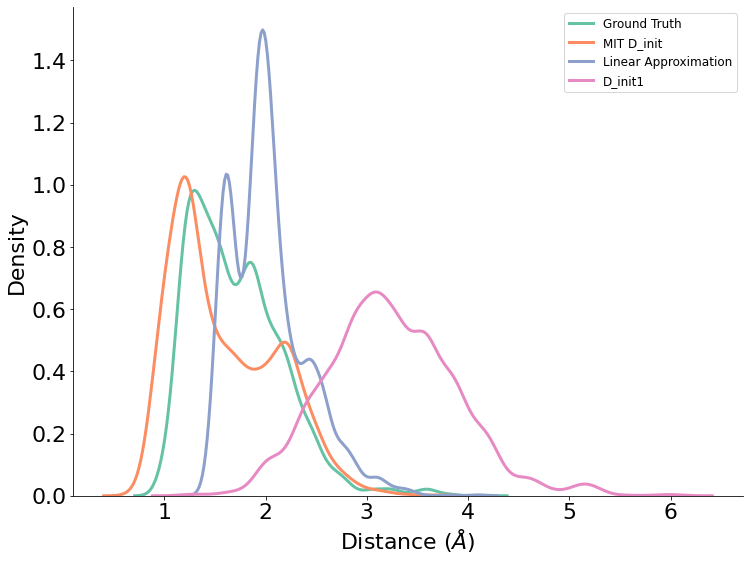

In [16]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
# no_print = ['lin_approx']

for i, key in enumerate(ds_dict.keys()):
    #if key in no_print:
    #    continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

## Ensemble

Average all produced $D_{inits}s$ then plot.

In [82]:
ds_dict['D_init1'][0].shape, ds_dict['best_init'][0].shape

((4346,), (4346,))

In [83]:
# averaged ensemble of d_inits
ensemble_ds = []
d_inits
for i in range(len(ds_dict['best_init'][0])):
    ensemble_d = 0
    for j in range(1, num_d_inits + 1):
        ensemble_d += ds_dict[f'D_init{j}'][0][i]
    ensemble_d /= num_d_inits
    ensemble_ds.append(ensemble_d)

ds_dict['ens'] = (ensemble_ds, "Avg Ensemble D_init")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

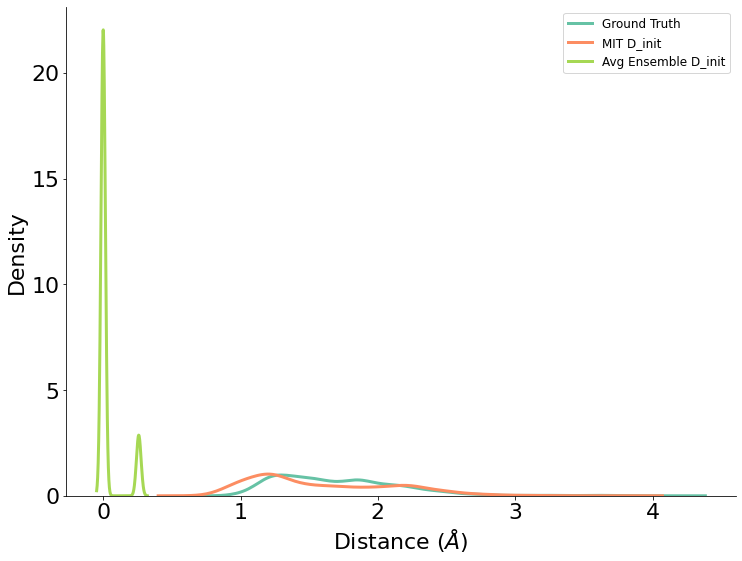

In [84]:
fig, ax = plt.subplots(figsize=(12,9))

num_to_plot = len(ds_dict)
cols = sns.color_palette("Set2", num_to_plot)

# keys: 'gt', 'lin_approx', 'best_init', f'D_init{i}'
no_print = ['lin_approx']
print_d_init = False
if not print_d_init:
    for j in range(1, num_d_inits + 1):
        no_print.append(f'D_init{j}')

for i, key in enumerate(ds_dict.keys()):
    if key in no_print:
        continue
    sns.distplot(ds_dict[key][0], color=cols[i], kde_kws={"lw": 3, "label": ds_dict[key][1]}, hist=False)

ax.legend(loc='upper right')
ax.legend(fontsize=12)
ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 